In [2]:
import json

with open("data.json", "r", encoding="utf-8") as file:
    data = json.load(file)

question_count = sum(len(topic["questions"]) for chapter in data["data"] for topic in chapter["topics"])

print("Total number of questions:", question_count)


Total number of questions: 162


In [110]:


PROMPT_text = """
Hãy giải bài toán theo từng bước, và giải thích bước làm.
Hãy trả về kết quả dạng LaTeX cho các công thức toán học (để trong $...$ cho các biểu thức, số), bảng biến thiên, đồ thị,... nếu có.

=========
Đây là bài toán:
{problem}

=========

LƯU Ý: 
- Hãy giải bằng cách ngắn gọn, hiệu quả nhất.
- Hãy trình bày khoa học và dùng các ký hiệu toán học nếu có thể để thay cho chữ 
- Ví dụ dùng kí hiệu toán là dấu "hoặc", "và" khi giải phương trình, bất phương trình; Hay vẽ bảng biến thiên khảo sát hàm số hay xét dấu,.... 
- Nên xuống dòng khi cần thiết, tránh một dòng quá dài.
-Trả về dưới dạng tag : <solution>solution<solution> <answer>answer<answer> trong đó solution là cách giải, anser là kết quả cuối cùng theo yêu cầu bài toán.
-Trả về kết quả dưới dạng Latex
"""

In [1]:

from dotenv import load_dotenv
import os
from google import genai

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
gemini_api_key = os.getenv("GEMINI_API_KEY")

from langchain_openai import OpenAI, ChatOpenAI
from typing import List, Dict, Any, Optional, Tuple
from abc import ABC, abstractmethod
from langchain.schema.messages import HumanMessage, SystemMessage


class LLM(ABC):
    @abstractmethod
    def generate(self, prompt: str) -> str:
        pass
    
    @abstractmethod
    def stream_generate(self, prompt: str):
        pass

class LangchainOpenAI(LLM):
    def __init__(self, model_name="gpt-4o"):
        self.chat_model = ChatOpenAI(
            model=model_name,
            temperature=0
        )
        self.stream_model = ChatOpenAI(
            model=model_name,
            temperature=0,
            streaming=True
        )
    
    def generate(self, prompt: str) -> str:
        messages = [HumanMessage(content=prompt)]
        return self.chat_model.invoke(messages).content
    
    def stream_generate(self, prompt: str):
        messages = [HumanMessage(content=prompt)]
        for chunk in self.stream_model.stream(messages):
            if chunk.content:
                yield chunk.content

class GeminiAI(LLM):
    def __init__(self):
        self.client = genai.Client(api_key=gemini_api_key)
    
    def generate(self, prompt: str) -> str:
        response = self.client.models.generate_content(model="gemini-2.0-flash",contents=[prompt])
        return response.text
    

    def stream_generate(self, prompt: str):
        response = self.client.models.generate_content_stream(model="gemini-2.0-flash",contents=[prompt])
        
        for chunk in response:
            if chunk.text:
                yield chunk.text

In [143]:

import re
import pandas as pd

from IPython.display import display, Latex
import json

from tqdm import tqdm

model = GeminiAI()
def get_answer(problem):
    response =  model.generate(PROMPT_text.format(problem=problem))
    if response is None:
            return {"solution": "AI failed to generate a solution", "answer": "AI failed to generate an answer"}
    solution_match = re.search(r"<solution>(.*?)</solution>", response, re.DOTALL)
    answer_match = re.search(r"<answer>(.*?)</answer>", response, re.DOTALL)
    
    # Extracted values or default
    solution = solution_match.group(1) if solution_match else "No solution found"
    answer = answer_match.group(1) if answer_match else "No answer found"
    
    return {"solution": solution, "answer": answer}

In [144]:
rows = []
questions_list = [q for chapter in data["data"] for topic in chapter["topics"] for q in topic["questions"]]

for q in tqdm(questions_list, desc="Processing Questions"):
    ai_response = get_answer(q["question"])
    display(Latex(ai_response["solution"]))
    rows.append([
        q["question"], 
        q["solution"], 
        q["answer"], 
        ai_response["solution"], 
        ai_response["answer"]
    ])

# Create DataFrame
df = pd.DataFrame(rows, columns=["Question", "Solution", "Answer", "AI Solution", "AI Answer"])


# Display DataFrame
display(df)

Processing Questions:   0%|          | 0/162 [00:00<?, ?it/s]

<IPython.core.display.Latex object>

Processing Questions:   1%|          | 1/162 [00:02<05:22,  2.00s/it]

<IPython.core.display.Latex object>

Processing Questions:   1%|          | 2/162 [00:04<05:20,  2.00s/it]

<IPython.core.display.Latex object>

Processing Questions:   2%|▏         | 3/162 [00:07<07:33,  2.85s/it]

<IPython.core.display.Latex object>

Processing Questions:   2%|▏         | 4/162 [00:11<08:16,  3.14s/it]

<IPython.core.display.Latex object>

Processing Questions:   3%|▎         | 5/162 [00:15<08:38,  3.30s/it]

<IPython.core.display.Latex object>

Processing Questions:   4%|▎         | 6/162 [00:18<08:55,  3.43s/it]

<IPython.core.display.Latex object>

Processing Questions:   4%|▍         | 7/162 [00:22<09:25,  3.65s/it]

<IPython.core.display.Latex object>

Processing Questions:   5%|▍         | 8/162 [00:26<09:33,  3.73s/it]

<IPython.core.display.Latex object>

Processing Questions:   6%|▌         | 9/162 [00:29<08:25,  3.30s/it]

<IPython.core.display.Latex object>

Processing Questions:   6%|▌         | 10/162 [00:32<08:29,  3.35s/it]

<IPython.core.display.Latex object>

Processing Questions:   7%|▋         | 11/162 [00:35<08:25,  3.35s/it]

<IPython.core.display.Latex object>

Processing Questions:   7%|▋         | 12/162 [00:39<08:44,  3.49s/it]

<IPython.core.display.Latex object>

Processing Questions:   8%|▊         | 13/162 [00:43<08:50,  3.56s/it]

<IPython.core.display.Latex object>

Processing Questions:   9%|▊         | 14/162 [00:49<10:36,  4.30s/it]

<IPython.core.display.Latex object>

Processing Questions:   9%|▉         | 15/162 [00:54<10:59,  4.49s/it]

<IPython.core.display.Latex object>

Processing Questions:  10%|▉         | 16/162 [00:58<10:34,  4.34s/it]

<IPython.core.display.Latex object>

Processing Questions:  10%|█         | 17/162 [01:01<09:46,  4.05s/it]

<IPython.core.display.Latex object>

Processing Questions:  11%|█         | 18/162 [01:05<09:40,  4.03s/it]

<IPython.core.display.Latex object>

Processing Questions:  12%|█▏        | 19/162 [01:09<09:08,  3.84s/it]

<IPython.core.display.Latex object>

Processing Questions:  12%|█▏        | 20/162 [01:14<10:14,  4.33s/it]

<IPython.core.display.Latex object>

Processing Questions:  13%|█▎        | 21/162 [01:17<09:23,  4.00s/it]

<IPython.core.display.Latex object>

Processing Questions:  14%|█▎        | 22/162 [01:20<08:29,  3.64s/it]

<IPython.core.display.Latex object>

Processing Questions:  14%|█▍        | 23/162 [01:24<08:39,  3.73s/it]

<IPython.core.display.Latex object>

Processing Questions:  15%|█▍        | 24/162 [01:29<09:15,  4.03s/it]

<IPython.core.display.Latex object>

Processing Questions:  15%|█▌        | 25/162 [01:32<08:53,  3.89s/it]

<IPython.core.display.Latex object>

Processing Questions:  16%|█▌        | 26/162 [01:36<08:32,  3.77s/it]

<IPython.core.display.Latex object>

Processing Questions:  17%|█▋        | 27/162 [01:42<09:56,  4.42s/it]

<IPython.core.display.Latex object>

Processing Questions:  17%|█▋        | 28/162 [01:45<09:18,  4.17s/it]

<IPython.core.display.Latex object>

Processing Questions:  18%|█▊        | 29/162 [01:51<10:09,  4.58s/it]

<IPython.core.display.Latex object>

Processing Questions:  19%|█▊        | 30/162 [01:58<11:50,  5.38s/it]

<IPython.core.display.Latex object>

Processing Questions:  19%|█▉        | 31/162 [02:03<11:26,  5.24s/it]

<IPython.core.display.Latex object>

Processing Questions:  20%|█▉        | 32/162 [02:07<10:24,  4.81s/it]

<IPython.core.display.Latex object>

Processing Questions:  20%|██        | 33/162 [02:10<09:04,  4.22s/it]

<IPython.core.display.Latex object>

Processing Questions:  21%|██        | 34/162 [02:14<09:11,  4.31s/it]

<IPython.core.display.Latex object>

Processing Questions:  22%|██▏       | 35/162 [02:19<09:34,  4.52s/it]

<IPython.core.display.Latex object>

Processing Questions:  22%|██▏       | 36/162 [02:24<09:29,  4.52s/it]

<IPython.core.display.Latex object>

Processing Questions:  23%|██▎       | 37/162 [02:27<08:34,  4.11s/it]

<IPython.core.display.Latex object>

Processing Questions:  23%|██▎       | 38/162 [02:30<07:33,  3.65s/it]

<IPython.core.display.Latex object>

Processing Questions:  24%|██▍       | 39/162 [02:33<07:07,  3.47s/it]

<IPython.core.display.Latex object>

Processing Questions:  25%|██▍       | 40/162 [02:37<07:26,  3.66s/it]

<IPython.core.display.Latex object>

Processing Questions:  25%|██▌       | 41/162 [02:44<09:37,  4.77s/it]

<IPython.core.display.Latex object>

Processing Questions:  26%|██▌       | 42/162 [02:49<09:26,  4.72s/it]

<IPython.core.display.Latex object>

Processing Questions:  27%|██▋       | 43/162 [02:52<08:41,  4.38s/it]

<IPython.core.display.Latex object>

Processing Questions:  27%|██▋       | 44/162 [02:56<08:26,  4.29s/it]

<IPython.core.display.Latex object>

Processing Questions:  28%|██▊       | 45/162 [03:03<09:42,  4.97s/it]

<IPython.core.display.Latex object>

Processing Questions:  28%|██▊       | 46/162 [03:08<09:45,  5.05s/it]

<IPython.core.display.Latex object>

Processing Questions:  29%|██▉       | 47/162 [03:12<09:03,  4.72s/it]

<IPython.core.display.Latex object>

Processing Questions:  30%|██▉       | 48/162 [03:16<08:45,  4.61s/it]

<IPython.core.display.Latex object>

Processing Questions:  30%|███       | 49/162 [03:24<10:17,  5.47s/it]

<IPython.core.display.Latex object>

Processing Questions:  31%|███       | 50/162 [03:30<10:48,  5.79s/it]

<IPython.core.display.Latex object>

Processing Questions:  31%|███▏      | 51/162 [03:36<10:37,  5.74s/it]

<IPython.core.display.Latex object>

Processing Questions:  32%|███▏      | 52/162 [03:41<10:07,  5.53s/it]

<IPython.core.display.Latex object>

Processing Questions:  33%|███▎      | 53/162 [03:45<09:22,  5.16s/it]

<IPython.core.display.Latex object>

Processing Questions:  33%|███▎      | 54/162 [03:52<09:59,  5.55s/it]

<IPython.core.display.Latex object>

Processing Questions:  34%|███▍      | 55/162 [03:56<09:06,  5.11s/it]

<IPython.core.display.Latex object>

Processing Questions:  35%|███▍      | 56/162 [04:03<09:50,  5.57s/it]

<IPython.core.display.Latex object>

Processing Questions:  35%|███▌      | 57/162 [04:08<09:36,  5.49s/it]

<IPython.core.display.Latex object>

Processing Questions:  36%|███▌      | 58/162 [04:11<08:14,  4.75s/it]

<IPython.core.display.Latex object>

Processing Questions:  36%|███▋      | 59/162 [04:14<07:29,  4.36s/it]

<IPython.core.display.Latex object>

Processing Questions:  37%|███▋      | 60/162 [04:18<07:01,  4.13s/it]

<IPython.core.display.Latex object>

Processing Questions:  38%|███▊      | 61/162 [04:20<05:54,  3.51s/it]

<IPython.core.display.Latex object>

Processing Questions:  38%|███▊      | 62/162 [04:26<07:09,  4.30s/it]

<IPython.core.display.Latex object>

Processing Questions:  39%|███▉      | 63/162 [04:36<09:49,  5.96s/it]

<IPython.core.display.Latex object>

Processing Questions:  40%|███▉      | 64/162 [04:51<14:13,  8.71s/it]

<IPython.core.display.Latex object>

Processing Questions:  40%|████      | 65/162 [04:58<13:02,  8.07s/it]

<IPython.core.display.Latex object>

Processing Questions:  41%|████      | 66/162 [05:00<10:15,  6.41s/it]

<IPython.core.display.Latex object>

Processing Questions:  41%|████▏     | 67/162 [05:04<08:50,  5.59s/it]

<IPython.core.display.Latex object>

Processing Questions:  42%|████▏     | 68/162 [05:08<07:53,  5.04s/it]

<IPython.core.display.Latex object>

Processing Questions:  43%|████▎     | 69/162 [05:13<07:47,  5.02s/it]

<IPython.core.display.Latex object>

Processing Questions:  43%|████▎     | 70/162 [05:16<07:07,  4.64s/it]

<IPython.core.display.Latex object>

Processing Questions:  44%|████▍     | 71/162 [05:20<06:40,  4.40s/it]

<IPython.core.display.Latex object>

Processing Questions:  44%|████▍     | 72/162 [05:24<06:18,  4.20s/it]

<IPython.core.display.Latex object>

Processing Questions:  45%|████▌     | 73/162 [05:27<05:44,  3.87s/it]

<IPython.core.display.Latex object>

Processing Questions:  46%|████▌     | 74/162 [05:36<07:59,  5.44s/it]

<IPython.core.display.Latex object>

Processing Questions:  46%|████▋     | 75/162 [05:41<07:45,  5.35s/it]

<IPython.core.display.Latex object>

Processing Questions:  47%|████▋     | 76/162 [05:46<07:31,  5.25s/it]

<IPython.core.display.Latex object>

Processing Questions:  48%|████▊     | 77/162 [05:52<07:30,  5.30s/it]

<IPython.core.display.Latex object>

Processing Questions:  48%|████▊     | 78/162 [05:58<07:38,  5.46s/it]

<IPython.core.display.Latex object>

Processing Questions:  49%|████▉     | 79/162 [06:06<08:51,  6.40s/it]

<IPython.core.display.Latex object>

Processing Questions:  49%|████▉     | 80/162 [06:10<07:33,  5.53s/it]

<IPython.core.display.Latex object>

Processing Questions:  50%|█████     | 81/162 [06:14<06:52,  5.10s/it]

<IPython.core.display.Latex object>

Processing Questions:  51%|█████     | 82/162 [06:18<06:31,  4.89s/it]

<IPython.core.display.Latex object>

Processing Questions:  51%|█████     | 83/162 [06:21<05:26,  4.13s/it]

<IPython.core.display.Latex object>

Processing Questions:  52%|█████▏    | 84/162 [06:24<05:02,  3.87s/it]

<IPython.core.display.Latex object>

Processing Questions:  52%|█████▏    | 85/162 [06:28<04:58,  3.88s/it]

<IPython.core.display.Latex object>

Processing Questions:  53%|█████▎    | 86/162 [06:32<05:11,  4.10s/it]

<IPython.core.display.Latex object>

Processing Questions:  54%|█████▎    | 87/162 [06:38<05:34,  4.46s/it]

<IPython.core.display.Latex object>

Processing Questions:  54%|█████▍    | 88/162 [06:42<05:35,  4.54s/it]

<IPython.core.display.Latex object>

Processing Questions:  55%|█████▍    | 89/162 [06:48<05:50,  4.81s/it]

<IPython.core.display.Latex object>

Processing Questions:  56%|█████▌    | 90/162 [06:51<05:10,  4.32s/it]

<IPython.core.display.Latex object>

Processing Questions:  56%|█████▌    | 91/162 [06:55<05:01,  4.25s/it]

<IPython.core.display.Latex object>

Processing Questions:  57%|█████▋    | 92/162 [07:00<05:07,  4.39s/it]

<IPython.core.display.Latex object>

Processing Questions:  57%|█████▋    | 93/162 [07:05<05:29,  4.78s/it]

<IPython.core.display.Latex object>

Processing Questions:  58%|█████▊    | 94/162 [07:09<04:56,  4.36s/it]

<IPython.core.display.Latex object>

Processing Questions:  59%|█████▊    | 95/162 [07:13<04:49,  4.32s/it]

<IPython.core.display.Latex object>

Processing Questions:  59%|█████▉    | 96/162 [07:18<05:07,  4.65s/it]

<IPython.core.display.Latex object>

Processing Questions:  60%|█████▉    | 97/162 [07:25<05:47,  5.35s/it]

<IPython.core.display.Latex object>

Processing Questions:  60%|██████    | 98/162 [07:29<05:16,  4.94s/it]

<IPython.core.display.Latex object>

Processing Questions:  61%|██████    | 99/162 [07:32<04:30,  4.29s/it]

<IPython.core.display.Latex object>

Processing Questions:  62%|██████▏   | 100/162 [07:38<04:55,  4.76s/it]

<IPython.core.display.Latex object>

Processing Questions:  62%|██████▏   | 101/162 [07:43<04:56,  4.86s/it]

<IPython.core.display.Latex object>

Processing Questions:  63%|██████▎   | 102/162 [07:48<04:54,  4.91s/it]

<IPython.core.display.Latex object>

Processing Questions:  64%|██████▎   | 103/162 [07:52<04:26,  4.51s/it]

<IPython.core.display.Latex object>

Processing Questions:  64%|██████▍   | 104/162 [07:58<04:53,  5.06s/it]

<IPython.core.display.Latex object>

Processing Questions:  65%|██████▍   | 105/162 [08:03<04:44,  4.99s/it]

<IPython.core.display.Latex object>

Processing Questions:  65%|██████▌   | 106/162 [08:08<04:36,  4.93s/it]

<IPython.core.display.Latex object>

Processing Questions:  66%|██████▌   | 107/162 [08:12<04:24,  4.81s/it]

<IPython.core.display.Latex object>

Processing Questions:  67%|██████▋   | 108/162 [08:16<04:06,  4.56s/it]

<IPython.core.display.Latex object>

Processing Questions:  67%|██████▋   | 109/162 [08:19<03:39,  4.15s/it]

<IPython.core.display.Latex object>

Processing Questions:  68%|██████▊   | 110/162 [08:24<03:44,  4.32s/it]

<IPython.core.display.Latex object>

Processing Questions:  69%|██████▊   | 111/162 [08:27<03:16,  3.85s/it]

<IPython.core.display.Latex object>

Processing Questions:  69%|██████▉   | 112/162 [08:30<03:00,  3.61s/it]

<IPython.core.display.Latex object>

Processing Questions:  70%|██████▉   | 113/162 [08:34<03:05,  3.79s/it]

<IPython.core.display.Latex object>

Processing Questions:  70%|███████   | 114/162 [08:37<02:53,  3.61s/it]

<IPython.core.display.Latex object>

Processing Questions:  71%|███████   | 115/162 [08:42<03:04,  3.94s/it]

<IPython.core.display.Latex object>

Processing Questions:  72%|███████▏  | 116/162 [08:45<02:41,  3.51s/it]

<IPython.core.display.Latex object>

Processing Questions:  72%|███████▏  | 117/162 [08:48<02:42,  3.61s/it]

<IPython.core.display.Latex object>

Processing Questions:  73%|███████▎  | 118/162 [08:52<02:37,  3.58s/it]

<IPython.core.display.Latex object>

Processing Questions:  73%|███████▎  | 119/162 [08:55<02:25,  3.39s/it]

<IPython.core.display.Latex object>

Processing Questions:  74%|███████▍  | 120/162 [08:59<02:28,  3.54s/it]

<IPython.core.display.Latex object>

Processing Questions:  75%|███████▍  | 121/162 [09:03<02:30,  3.67s/it]

<IPython.core.display.Latex object>

Processing Questions:  75%|███████▌  | 122/162 [09:07<02:34,  3.86s/it]

<IPython.core.display.Latex object>

Processing Questions:  76%|███████▌  | 123/162 [09:11<02:37,  4.03s/it]

<IPython.core.display.Latex object>

Processing Questions:  77%|███████▋  | 124/162 [09:18<03:01,  4.78s/it]

<IPython.core.display.Latex object>

Processing Questions:  77%|███████▋  | 125/162 [09:23<03:01,  4.92s/it]

<IPython.core.display.Latex object>

Processing Questions:  78%|███████▊  | 126/162 [09:28<02:53,  4.82s/it]

<IPython.core.display.Latex object>

Processing Questions:  78%|███████▊  | 127/162 [09:33<02:56,  5.03s/it]

<IPython.core.display.Latex object>

Processing Questions:  79%|███████▉  | 128/162 [09:39<02:59,  5.28s/it]

<IPython.core.display.Latex object>

Processing Questions:  80%|███████▉  | 129/162 [09:44<02:53,  5.26s/it]

<IPython.core.display.Latex object>

Processing Questions:  80%|████████  | 130/162 [09:49<02:42,  5.09s/it]

<IPython.core.display.Latex object>

Processing Questions:  81%|████████  | 131/162 [09:53<02:26,  4.72s/it]

<IPython.core.display.Latex object>

Processing Questions:  81%|████████▏ | 132/162 [09:56<02:09,  4.32s/it]

<IPython.core.display.Latex object>

Processing Questions:  82%|████████▏ | 133/162 [09:59<01:53,  3.93s/it]

<IPython.core.display.Latex object>

Processing Questions:  83%|████████▎ | 134/162 [10:03<01:46,  3.81s/it]

<IPython.core.display.Latex object>

Processing Questions:  83%|████████▎ | 135/162 [10:15<02:47,  6.21s/it]

<IPython.core.display.Latex object>

Processing Questions:  84%|████████▍ | 136/162 [10:19<02:26,  5.64s/it]

<IPython.core.display.Latex object>

Processing Questions:  85%|████████▍ | 137/162 [10:25<02:26,  5.85s/it]

<IPython.core.display.Latex object>

Processing Questions:  85%|████████▌ | 138/162 [10:27<01:50,  4.62s/it]

<IPython.core.display.Latex object>

Processing Questions:  86%|████████▌ | 139/162 [10:33<01:57,  5.11s/it]

<IPython.core.display.Latex object>

Processing Questions:  86%|████████▋ | 140/162 [10:38<01:46,  4.84s/it]

<IPython.core.display.Latex object>

Processing Questions:  87%|████████▋ | 141/162 [10:43<01:44,  4.98s/it]

<IPython.core.display.Latex object>

Processing Questions:  88%|████████▊ | 142/162 [10:50<01:54,  5.72s/it]

<IPython.core.display.Latex object>

Processing Questions:  88%|████████▊ | 143/162 [10:55<01:44,  5.51s/it]

<IPython.core.display.Latex object>

Processing Questions:  89%|████████▉ | 144/162 [11:00<01:36,  5.36s/it]

<IPython.core.display.Latex object>

Processing Questions:  90%|████████▉ | 145/162 [11:07<01:36,  5.66s/it]

<IPython.core.display.Latex object>

Processing Questions:  90%|█████████ | 146/162 [11:12<01:27,  5.45s/it]

<IPython.core.display.Latex object>

Processing Questions:  91%|█████████ | 147/162 [11:15<01:13,  4.92s/it]

<IPython.core.display.Latex object>

Processing Questions:  91%|█████████▏| 148/162 [11:20<01:08,  4.92s/it]

<IPython.core.display.Latex object>

Processing Questions:  92%|█████████▏| 149/162 [11:25<01:04,  4.95s/it]

<IPython.core.display.Latex object>

Processing Questions:  93%|█████████▎| 150/162 [11:31<01:00,  5.06s/it]

<IPython.core.display.Latex object>

Processing Questions:  93%|█████████▎| 151/162 [11:36<00:57,  5.23s/it]

<IPython.core.display.Latex object>

Processing Questions:  94%|█████████▍| 152/162 [11:42<00:52,  5.26s/it]

<IPython.core.display.Latex object>

Processing Questions:  94%|█████████▍| 153/162 [11:47<00:46,  5.22s/it]

<IPython.core.display.Latex object>

Processing Questions:  95%|█████████▌| 154/162 [11:50<00:38,  4.81s/it]

<IPython.core.display.Latex object>

Processing Questions:  96%|█████████▌| 155/162 [11:58<00:38,  5.47s/it]

<IPython.core.display.Latex object>

Processing Questions:  96%|█████████▋| 156/162 [12:05<00:37,  6.22s/it]

<IPython.core.display.Latex object>

Processing Questions:  97%|█████████▋| 157/162 [12:09<00:27,  5.55s/it]

<IPython.core.display.Latex object>

Processing Questions:  98%|█████████▊| 158/162 [12:14<00:20,  5.16s/it]

<IPython.core.display.Latex object>

Processing Questions:  98%|█████████▊| 159/162 [12:18<00:14,  4.95s/it]

<IPython.core.display.Latex object>

Processing Questions:  99%|█████████▉| 160/162 [12:23<00:09,  4.82s/it]

<IPython.core.display.Latex object>

Processing Questions:  99%|█████████▉| 161/162 [12:28<00:04,  4.88s/it]

<IPython.core.display.Latex object>

Processing Questions: 100%|██████████| 162/162 [12:33<00:00,  4.65s/it]


,Question,Solution,Answer,AI Solution,AI Answer
0,Cho hai số phức $z_1 = 1 + 10i$ và $z_2 = 9 – ...,Ta có: $z = z_1 + z_2 = (1 + 10i) + ( 9 – 2i) ...,10,"\nĐể tìm số phức $z = z_1 + z_2$, ta thực hiện...",\n$10$\n
1,Hãy tính số phức z. Biết rằng: $z = 10i – ( 2 ...,Ta có: $z = 10i - (2 + 2i).i = 10i – 2i + 2 = ...,2 + 8i,"\nĐể tính số phức $z$, ta thực hiện các phép t...",\n$z = 2 + 8i$\n
2,Cho hai số phức $z = -2 + 3yi$; $z’ = ( x + 1)...,Để $z + i = z’ + 2$ => - 2 + 3yi + i = ( x + 1...,"x = -5, y = -5/3",\nTa có:\n$z = -2 + 3yi$\n$z' = (x+1) - 4i$\n$...,\n$x = -5$\n$y = -\frac{5}{3}$\n
3,Số nào trong các số phức sau là số thuần ảo? A...,Ta xét các phương án:A.(√2 + i) - (1 + √2i)= (...,B. ( 8 + 2i) + (- 8 + 2i),"\nĐể một số phức là số thuần ảo, phần thực của...",\nB. $(8 + 2i) + (- 8 + 2i)$\n
4,Tính giá trị của P = i^{105} + i^{23} + i^{20}...,"Ta có: $i^2 = -1 \Rightarrow i^4 = 1$. Do đó, ...",2,"\nTa có $i$ là đơn vị ảo, thỏa mãn $i^2 = -1$....",\n$P = 2$\n
...,...,...,...,...,...
157,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Phương trình hoành độ giao điểm:\n$2x-x^2 = 0 ...,16/15pi,\nĐể tính thể tích khối tròn xoay tạo thành kh...,\n$V = \frac{16\pi}{15}$\n
158,Tính thể tích khối tròn xoay được giới hạn bởi...,Thể tích khối tròn xoay được giới hạn bởi các ...,46/15pi,\nBài toán yêu cầu tính thể tích khối tròn xoa...,\n$V = \frac{46\pi}{15}$\n
159,Cho hình phẳng giới hạn bởi các đường y=\sqrt{...,Giải phương trình $\sqrt{x} = x \Leftrightarro...,pi/6,"\nĐể giải bài toán này, ta thực hiện các bước ...",\n$V = \frac{\pi}{6}$\n
160,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Thể tích khối tròn xoay được giới hạn bởi các ...,pi - pi^2/4,\nĐể tính thể tích khối tròn xoay tạo thành kh...,\n$V = \pi - \frac{\pi^2}{4}$\n


In [7]:
import pandas as pd
df = pd.read_csv("ai_test_results.csv")

In [8]:
import time
import re
import pandas as pd
from tqdm import tqdm

# Function to classify AI answer correctness

model = GeminiAI()

def check_answer(correct_answer, ai_answer):
    prompt = (f'''Compare the correct answer '{correct_answer}' with the AI-generated answer '{ai_answer}'. 
              Categorize the result into one of the following:
              1. 'Both Correct' - AI answer is meaningfully correct.
              2. 'Both Incorrect' - AI uses incorrect reasoning, both is incorrect.
              3. 'Correct Answer, Wrong Explanation' - The answer is correct, but the reasoning is flawed.
              4. 'Wrong Answer, Correct Explanation' - The answer is wrong, but the reasoning is valid.
              5. 'AI Not Generated' - AI did not produce an answer.
              
              Be lenient in formatting and minor differences as long as the meaning aligns. 
              Return only the category and a brief explanation.
              ''')

    global last_api_call_time
    elapsed_time = time.time() - last_api_call_time
    if elapsed_time < 4:
        time.sleep(4 - elapsed_time)  # Enforce rate limit

    response = model.generate(prompt)
    last_api_call_time = time.time()

    if response is None:
        return "AI Not Generated", "AI failed to generate a response"

    match = re.search(r"(Both Correct|Both Incorrect|Correct Answer, Wrong Explanation|Wrong Answer, Correct Explanation|AI Not Generated)", response)
    explanation_match = re.search(r"Explanation:\s*(.*)", response, re.DOTALL)
    
    category = match.group(1) if match else "Unknown"
    explanation = explanation_match.group(1).strip() if explanation_match else "No explanation provided"
    
    return category, explanation

# Initialize rate limit tracking
last_api_call_time = time.time()

# Ensure necessary columns exist
if "Category" not in df.columns:
    df["Category"] = None
if "Explanation" not in df.columns:
    df["Explanation"] = None

# Iterate through DataFrame
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Checking AI Answers"):
    if pd.notna(row["Category"]):
        continue
    
    category, explanation = check_answer(row["Answer"], row["AI Answer"])
    df.at[index, "Category"] = category
    df.at[index, "Explanation"] = explanation

# Display updated DataFrame
display(df)


Checking AI Answers: 100%|██████████| 162/162 [15:53<00:00,  5.89s/it]


,Unnamed: 0,Question,Solution,Answer,AI Solution,AI Answer,Category,Explanation
0,0,Cho hai số phức $z_1 = 1 + 10i$ và $z_2 = 9 – ...,Ta có: $z = z_1 + z_2 = (1 + 10i) + ( 9 – 2i) ...,10,"\nĐể tìm số phức $z = z_1 + z_2$, ta thực hiện...",\n$10$\n,Both Correct,No explanation provided
1,1,Hãy tính số phức z. Biết rằng: $z = 10i – ( 2 ...,Ta có: $z = 10i - (2 + 2i).i = 10i – 2i + 2 = ...,2 + 8i,"\nĐể tính số phức $z$, ta thực hiện các phép t...",\n$z = 2 + 8i$\n,Both Correct,No explanation provided
2,2,Cho hai số phức $z = -2 + 3yi$; $z’ = ( x + 1)...,Để $z + i = z’ + 2$ => - 2 + 3yi + i = ( x + 1...,"x = -5, y = -5/3",\nTa có:\n$z = -2 + 3yi$\n$z' = (x+1) - 4i$\n$...,\n$x = -5$\n$y = -\frac{5}{3}$\n,Both Correct,No explanation provided
3,3,Số nào trong các số phức sau là số thuần ảo? A...,Ta xét các phương án:A.(√2 + i) - (1 + √2i)= (...,B. ( 8 + 2i) + (- 8 + 2i),"\nĐể một số phức là số thuần ảo, phần thực của...",\nB. $(8 + 2i) + (- 8 + 2i)$\n,Both Correct,No explanation provided
4,4,Tính giá trị của P = i^{105} + i^{23} + i^{20}...,"Ta có: $i^2 = -1 \Rightarrow i^4 = 1$. Do đó, ...",2,"\nTa có $i$ là đơn vị ảo, thỏa mãn $i^2 = -1$....",\n$P = 2$\n,Both Correct,No explanation provided
...,...,...,...,...,...,...,...,...
157,157,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Phương trình hoành độ giao điểm:\n$2x-x^2 = 0 ...,16/15pi,\nĐể tính thể tích khối tròn xoay tạo thành kh...,\n$V = \frac{16\pi}{15}$\n,Both Correct,No explanation provided
158,158,Tính thể tích khối tròn xoay được giới hạn bởi...,Thể tích khối tròn xoay được giới hạn bởi các ...,46/15pi,\nBài toán yêu cầu tính thể tích khối tròn xoa...,\n$V = \frac{46\pi}{15}$\n,Both Correct,No explanation provided
159,159,Cho hình phẳng giới hạn bởi các đường y=\sqrt{...,Giải phương trình $\sqrt{x} = x \Leftrightarro...,pi/6,"\nĐể giải bài toán này, ta thực hiện các bước ...",\n$V = \frac{\pi}{6}$\n,Both Correct,No explanation provided
160,160,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Thể tích khối tròn xoay được giới hạn bởi các ...,pi - pi^2/4,\nĐể tính thể tích khối tròn xoay tạo thành kh...,\n$V = \pi - \frac{\pi^2}{4}$\n,Both Correct,No explanation provided


Statistical Summary of AI Answer Classification:
Both Correct                         128
Both Incorrect                        13
Wrong Answer, Correct Explanation     11
Correct Answer, Wrong Explanation      8
AI Not Generated                       2
Name: Category, dtype: int64

Percentage Distribution:
Both Correct                         79.012346
Both Incorrect                        8.024691
Wrong Answer, Correct Explanation     6.790123
Correct Answer, Wrong Explanation     4.938272
AI Not Generated                      1.234568
Name: Category, dtype: float64


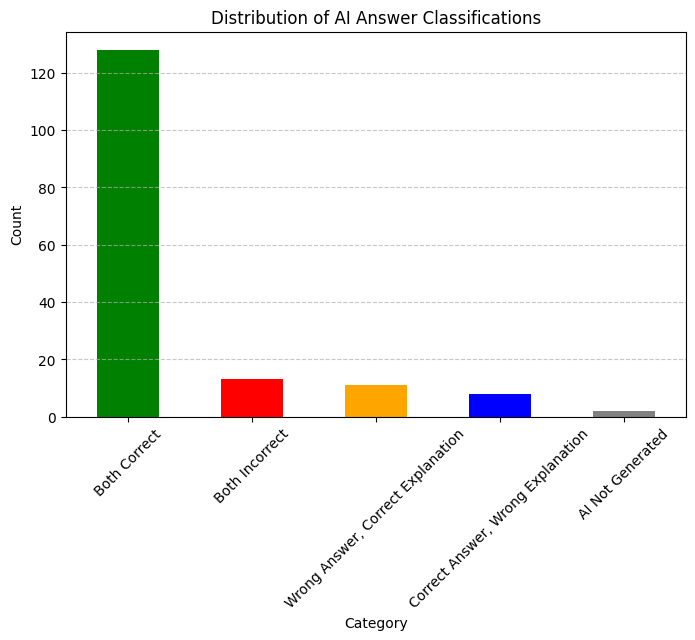

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each classification category
category_counts = df["Category"].value_counts()

# Compute percentages
category_percentages = (category_counts / len(df)) * 100

# Display statistical summary
print("Statistical Summary of AI Answer Classification:")
print(category_counts)
print("\nPercentage Distribution:")
print(category_percentages)

# Plot bar chart for better visualization
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color=["green", "red", "orange", "blue", "gray"])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of AI Answer Classifications")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [10]:
df.to_csv("gemini_test_results.csv")